In [1]:
import os
import anndata as an
import scanpy as sc
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn.decomposition import PCA
from deside.utility import ExpObj, set_fig_style
from deside.plot import plot_pca
from deside.utility.read_file import ReadH5AD
from matplotlib_venn import venn2
from sklearn.metrics import median_absolute_error
set_fig_style(font_family='Arial', font_size=8)

2024-01-04 18:24:34.215197: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


The part of PCA analysis needs about 35G memory, we plotted these figures on a computer server.

#### Single tumor type vs multiple tumor types

In [2]:
result_dir = '../results/whole_workflow_20231110_12ds_subtypes/DeSide_03_new_ds_subtypes_all_range/'
dataset_dir = r'../datasets/'
fig_dir = './fig1/'
sc.settings.figdir = fig_dir

In [3]:
# merged single cell dataset
sc_dataset = sc.read_h5ad(os.path.join(dataset_dir, 'single_cell', 'merged_12_sc_datasets_231003.h5ad'))

In [4]:
sc_dataset

AnnData object with n_obs × n_vars = 325474 × 17834
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'sample_id', 'batch', 'leiden1', 'dataset_id', 'original_cell_type', 'cell_type1', 'leiden', 'cell_type_first_round', 'cell_subtype', 'cell_type'
    var: 'gene_ids', 'n_cells', 'total_counts', 'n_counts'
    uns: 'cell_subtype_colors', 'cell_type1_colors', 'cell_type_colors', 'cell_type_first_round_colors', 'dataset_id_colors', 'dendrogram_leiden', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'original_cell_type_colors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [5]:
sc_dataset.obs.head(2)

,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,sample_id,batch,leiden1,dataset_id,original_cell_type,cell_type1,leiden,cell_type_first_round,cell_subtype,cell_type
AAACCTGAGCTGTCTA-1_HNSCC_1_TIL,2061,2044,9899.0,314.0,3.172038,hnscc_cillo_01_HNSCC_1_TIL,0,CD8 Tex,hnscc_cillo_01,,CD8 Tex,CD4 Treg (1),CD4 T,CD4 Treg,CD4 T
AAACCTGCAGCTGCTG-1_HNSCC_1_TIL,1261,1256,4692.0,118.0,2.514919,hnscc_cillo_01_HNSCC_1_TIL,0,CD4 T (3),hnscc_cillo_01,,CD4 T,Double-neg-like T (2),CD4 T,Double-neg-like T,Double-neg-like T


In [6]:
# downsampling for better plotting
selected = sc_dataset.obs.sample(n=20000)
selected.shape

(20000, 15)

In [7]:
list(sc_dataset.obs['dataset_id'].unique())

['hnscc_cillo_01',
 'pdac_peng_02',
 'hnscc_puram_03',
 'pdac_steele_04',
 'luad_kim_05',
 'nsclc_guo_06',
 'pan_cancer_07',
 'prad_cheng_08',
 'prad_dong_09',
 'hcc_sun_10',
 'gbm_neftel_11',
 'gbm_abdelfattah_12']

In [8]:
dataset_id2tumor_type = {'hnscc_cillo_01': 'Type 1', 'pdac_peng_02': 'Type 2', 'hnscc_puram_03': 'Type 1', 
                         'pdac_steele_04': 'Type 2', 'luad_kim_05': 'Type 3', 'nsclc_guo_06': 'Type 3',
                         'prad_cheng_08': 'Type 4', 'prad_dong_09': 'Type 4', 'hcc_sun_10': 'Type 5', 
                         'gbm_neftel_11': 'Type 6', 'gbm_abdelfattah_12': 'Type 6', 'pan_cancer_07': 'Cell lines'}
sc_dataset.obs['tumor_type'] = sc_dataset.obs['dataset_id'].map(dataset_id2tumor_type)
sc_dataset.obs.head(2)

,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,sample_id,batch,leiden1,dataset_id,original_cell_type,cell_type1,leiden,cell_type_first_round,cell_subtype,cell_type,tumor_type
AAACCTGAGCTGTCTA-1_HNSCC_1_TIL,2061,2044,9899.0,314.0,3.172038,hnscc_cillo_01_HNSCC_1_TIL,0,CD8 Tex,hnscc_cillo_01,,CD8 Tex,CD4 Treg (1),CD4 T,CD4 Treg,CD4 T,Type 1
AAACCTGCAGCTGCTG-1_HNSCC_1_TIL,1261,1256,4692.0,118.0,2.514919,hnscc_cillo_01_HNSCC_1_TIL,0,CD4 T (3),hnscc_cillo_01,,CD4 T,Double-neg-like T (2),CD4 T,Double-neg-like T,Double-neg-like T,Type 1


In [9]:
sc_umap = pd.DataFrame(data=sc_dataset.obsm['X_umap'], index=sc_dataset.obs.index, columns=['UMAP1', 'UMAP2'])
sc_umap = sc_umap.loc[sc_umap.index.isin(selected.index), :].copy()
sc_umap['tumor_type'] = sc_dataset.obs['tumor_type']
sc_umap.head(2)

,UMAP1,UMAP2,tumor_type
AACTTTCAGCTTCGCG-1_HNSCC_1_TIL,0.584889,13.788676,Type 1
AAGCCGCCAAGCCTAT-1_HNSCC_1_TIL,-2.443027,13.776449,Type 1


In [10]:
colors = [sns.color_palette("Set1")[i] for i in [1, 5, 0, 2, 3, 4, 6]]
sns.color_palette(colors)

[(0.21568627450980393, 0.49411764705882355, 0.7215686274509804),
 (1.0, 1.0, 0.2),
 (0.8941176470588236, 0.10196078431372549, 0.10980392156862745),
 (0.30196078431372547, 0.6862745098039216, 0.2901960784313726),
 (0.596078431372549, 0.3058823529411765, 0.6392156862745098),
 (1.0, 0.4980392156862745, 0.0),
 (0.6509803921568628, 0.33725490196078434, 0.1568627450980392)]

In [11]:
colors

[(0.21568627450980393, 0.49411764705882355, 0.7215686274509804),
 (1.0, 1.0, 0.2),
 (0.8941176470588236, 0.10196078431372549, 0.10980392156862745),
 (0.30196078431372547, 0.6862745098039216, 0.2901960784313726),
 (0.596078431372549, 0.3058823529411765, 0.6392156862745098),
 (1.0, 0.4980392156862745, 0.0),
 (0.6509803921568628, 0.33725490196078434, 0.1568627450980392)]

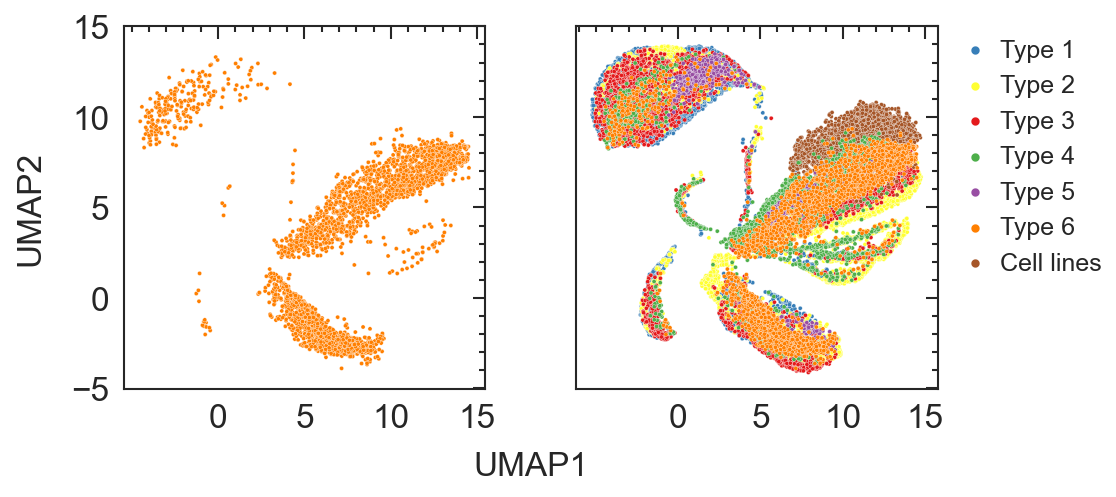

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(3.5, 1.6), sharey=True)
plt.subplots_adjust(wspace=0.25, hspace=0.25)

# g1 = sns.scatterplot(x='UMAP1', y='UMAP2', data=sc_umap.loc[sc_umap['tumor_type'] == 'Type 1', :], hue='tumor_type', s=5, ax=ax1, rasterized=True)
g1 = sns.scatterplot(x='UMAP1', y='UMAP2', data=sc_umap.loc[sc_umap['tumor_type'] == 'Type 6', :], 
                     hue='tumor_type', s=1, ax=ax1, rasterized=True, palette=[sns.color_palette('Set1')[4]])
g1.legend([],[], frameon=False)
# g1legend = g1.legend(fontsize=8, loc='lower right')
# g1legend.legendHandles[0].set_sizes([2])
# sns.move_legend(ax1, "lower left", bbox_to_anchor=(-.05, 1), ncol=2, title=None, frameon=False)
ax1.set_xlabel('')
ax1.set_xticks([0, 5, 10, 15])
ax1.set_ylabel('')
ax1.set_yticks([-5, 0, 5, 10, 15])
# ax1.tick_params(labelsize=12)

g2 = sns.scatterplot(x='UMAP1', y='UMAP2', data=sc_umap, hue='tumor_type', s=1, ax=ax2, rasterized=True, palette=colors, hue_order=['Type 1', 'Type 2', 'Type 3', 'Type 4', 'Type 5', 'Type 6', 'Cell lines'])
g2legend = g2.legend()
for _ in g2legend.legendHandles:
    _.set_sizes([1])
sns.move_legend(g2, "upper left", bbox_to_anchor=(1, 1), ncol=1, title=None, frameon=False, fontsize=6, borderpad=0, handletextpad=0)
ax2.set_xlabel('')
ax2.set_xticks([0, 5, 10, 15])
ax2.set_ylabel('')
ax2.set_yticks([-5, 0, 5, 10, 15])
# ax2.tick_params(labelsize=12)
# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
# plt.tight_layout()
plt.savefig(os.path.join(fig_dir, 'merged_sc_dataset_single_tumor_type.svg'), dpi=300)

In [13]:
del sc_dataset

#### Cell proportion

#### Sampling method comparison
- Generated cell proportion matrix (P) by each method
    - random sampling
    - segment

In [14]:
# tcga_tpm_file_path = '../datasets/TCGA/tpm/merged_tpm.csv'
N100K_random_file_path = '../datasets/simulated_bulk_cell_dataset_subtypes_all_range/random_12ds_n_base100/generated_frac_Mixed_N100K_random.csv'
N100K_segment_without_filtering_file_path = '../datasets/simulated_bulk_cell_dataset_subtypes_all_range/segment_12ds_no_filtering_n_base100_median_gep/generated_frac_Mixed_N100K_segment_without_filtering.csv'

In [15]:
n100k_random_cell_frac = pd.read_csv(N100K_random_file_path, index_col=0)
print(n100k_random_cell_frac.shape)
n100k_random_cell_frac.head(2)

(100000, 16)


,Non-plasma B cells,Plasma B cells,CD4 T,CD8 T (GZMK high),CD8 T effector,DC,Endothelial Cells,Cancer Cells,CAFs,Myofibroblasts,Macrophages,Mast Cells,NK,Neutrophils,Double-neg-like T,Monocytes
s_random_0_0,0.10,0.06,0.02,0.07,0.05,0.1,0.00,0.03,0.07,0.02,0.09,0.02,0.10,0.10,0.10,0.05
s_random_0_1,0.02,0.04,0.03,0.06,0.10,0.1,0.05,0.11,0.05,0.07,0.05,0.03,0.06,0.11,0.09,0.02


In [16]:
n100k_segment_cell_frac_no_filtering = pd.read_csv(N100K_segment_without_filtering_file_path, index_col=0)
print(n100k_segment_cell_frac_no_filtering.shape)
n100k_segment_cell_frac_no_filtering.head(2)

(100000, 16)


,Non-plasma B cells,Plasma B cells,CD4 T,CD8 T (GZMK high),CD8 T effector,DC,Endothelial Cells,Cancer Cells,CAFs,Myofibroblasts,Macrophages,Mast Cells,NK,Neutrophils,Double-neg-like T,Monocytes
s_segment_0_1,0.0164,0.0961,0.0036,0.0028,0.067,0.2436,0.1661,0.0293,0.3122,0.0132,0.0,0.0159,0.0155,0.0000,0.0002,0.0181
s_segment_0_10,0.0000,0.0000,0.3203,0.0009,0.000,0.0114,0.0000,0.0209,0.0020,0.0010,0.0,0.5790,0.0001,0.0589,0.0055,0.0000


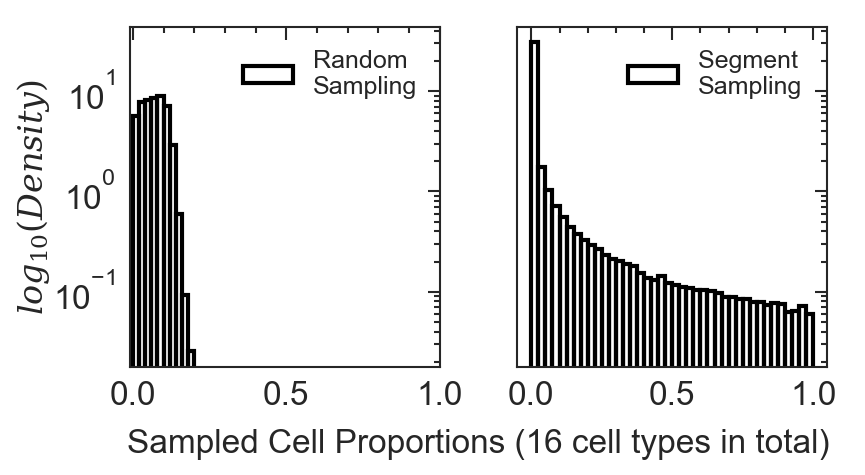

In [17]:
# plt.figure(figsize=(8, 6))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(3, 1.5), sharey=True)
plt.subplots_adjust(wspace=0.25, hspace=0.25)

ax1.hist(n100k_random_cell_frac['Cancer Cells'], label='Random \nSampling', density=True, histtype='bar', bins=10, fill=False, edgecolor='black')
ax1.set_yscale('log')
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.legend(fontsize=6, loc='upper right')
x_min, x_max = ax1.get_xlim()
ax1.set_xticks([0.0, 0.5, 1.0])
# ax1.text(x=0.35, y=0.00035, s='Cell prop.')

ax2.hist(n100k_segment_cell_frac_no_filtering['Cancer Cells'], label='Segment \nSampling', density=True, histtype='bar', bins=40, fill=False, edgecolor='black')
ax2.set_yscale('log')
ax2.set_xlabel('')
ax2.legend(fontsize=6, loc='upper right')

# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("Sampled Cell Proportions (16 cell types in total)")
plt.ylabel("$log_{10}(Density)$")

plt.savefig(os.path.join(fig_dir, 'cell_proportion_comparison.svg'), dpi=300)